라이브러리

In [1]:
# imports
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy
from tensorflow.keras.optimizers import Adam
import keras
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# 모델명(= 파일명) 설정
tank = 1
model_name = 'Test230717_tank1_nonlinear_crop_only-feed'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
time_ranges = [('03:00:00', '05:59:00'), ('15:00:00', '17:59:00')]

japonica_training_data_feed = []
japonica_validation_data_feed = []

for time_range in time_ranges:
    start_time, end_time = time_range
    japonica_training_data_feed.append(japonica_training_data.between_time(start_time, end_time))
    japonica_validation_data_feed.append(japonica_validation_data.between_time(start_time, end_time))
    

japonica_training_data = pd.concat(japonica_training_data_feed)
japonica_validation_data = pd.concat(japonica_validation_data_feed)

In [8]:
japonica_training_features_X = japonica_training_data[['feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [9]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)

In [10]:
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 16202 nVar: 1
nCar: 16202 nVar: 1
nCar: 16202 nVar: 1
nCar: 16202 nVar: 1


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [11]:
# Create model
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=1))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="relu"))
# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Fit the model
history = model.fit(japonica_training_features_X_chunks, japonica_training_features_y_chunks, validation_data=(japonica_validation_features_X_chunks, japonica_validation_features_y_chunks), epochs=10000000, batch_size=100, verbose=2, callbacks=[es])
model.save(model_name+'.h5')

2023-07-16 16:30:37.055872: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 16:30:37.736154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0
/home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2023-07-16 16:30:38.026777: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10000000


2023-07-16 16:30:39.382714: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


163/163 - 2s - loss: 36.6725 - val_loss: 1.5334
Epoch 2/10000000
163/163 - 1s - loss: 1.5054 - val_loss: 1.5030
Epoch 3/10000000
163/163 - 1s - loss: 1.5046 - val_loss: 1.5060
Epoch 4/10000000
163/163 - 1s - loss: 1.5054 - val_loss: 1.5037
Epoch 5/10000000
163/163 - 1s - loss: 1.5056 - val_loss: 1.5030
Epoch 6/10000000
163/163 - 1s - loss: 1.5057 - val_loss: 1.5168
Epoch 7/10000000
163/163 - 1s - loss: 1.5061 - val_loss: 1.5169
Epoch 8/10000000
163/163 - 1s - loss: 1.5146 - val_loss: 1.5092
Epoch 9/10000000
163/163 - 1s - loss: 1.5102 - val_loss: 1.5038
Epoch 10/10000000
163/163 - 1s - loss: 1.5084 - val_loss: 1.5191
Epoch 11/10000000
163/163 - 1s - loss: 1.5131 - val_loss: 1.5045
Epoch 12/10000000
163/163 - 1s - loss: 1.5099 - val_loss: 1.5039
Epoch 13/10000000
163/163 - 1s - loss: 1.5087 - val_loss: 1.5216
Epoch 14/10000000
163/163 - 1s - loss: 1.5114 - val_loss: 1.5082
Epoch 15/10000000
163/163 - 1s - loss: 1.5094 - val_loss: 1.5071
Epoch 16/10000000
163/163 - 1s - loss: 1.5069 - va

163/163 - 1s - loss: 1.5078 - val_loss: 1.5084
Epoch 128/10000000
163/163 - 1s - loss: 1.5132 - val_loss: 1.5040
Epoch 129/10000000
163/163 - 1s - loss: 1.5079 - val_loss: 1.5037
Epoch 130/10000000
163/163 - 1s - loss: 1.5112 - val_loss: 1.5039
Epoch 131/10000000
163/163 - 1s - loss: 1.5135 - val_loss: 1.5594
Epoch 132/10000000
163/163 - 1s - loss: 1.5138 - val_loss: 1.5151
Epoch 133/10000000
163/163 - 1s - loss: 1.5093 - val_loss: 1.5374
Epoch 134/10000000
163/163 - 1s - loss: 1.5149 - val_loss: 1.5064
Epoch 135/10000000
163/163 - 1s - loss: 1.5127 - val_loss: 1.5023
Epoch 136/10000000
163/163 - 1s - loss: 1.5100 - val_loss: 1.5412
Epoch 137/10000000
163/163 - 1s - loss: 1.5134 - val_loss: 1.5098
Epoch 138/10000000
163/163 - 1s - loss: 1.5094 - val_loss: 1.5089
Epoch 139/10000000
163/163 - 1s - loss: 1.5076 - val_loss: 1.5024
Epoch 140/10000000
163/163 - 1s - loss: 1.5085 - val_loss: 1.5039
Epoch 141/10000000
163/163 - 1s - loss: 1.5097 - val_loss: 1.5035
Epoch 142/10000000
163/163 - 

Epoch 252/10000000
163/163 - 1s - loss: 1.5094 - val_loss: 1.5158
Epoch 253/10000000
163/163 - 1s - loss: 1.5078 - val_loss: 1.5054
Epoch 254/10000000
163/163 - 1s - loss: 1.5082 - val_loss: 1.5048
Epoch 255/10000000
163/163 - 1s - loss: 1.5088 - val_loss: 1.5037
Epoch 256/10000000
163/163 - 1s - loss: 1.5144 - val_loss: 1.5027
Epoch 257/10000000
163/163 - 1s - loss: 1.5060 - val_loss: 1.5799
Epoch 258/10000000
163/163 - 1s - loss: 1.5168 - val_loss: 1.5058
Epoch 259/10000000
163/163 - 1s - loss: 1.5080 - val_loss: 1.5051
Epoch 260/10000000
163/163 - 1s - loss: 1.5078 - val_loss: 1.5027
Epoch 261/10000000
163/163 - 1s - loss: 1.5072 - val_loss: 1.5032
Epoch 262/10000000
163/163 - 1s - loss: 1.5102 - val_loss: 1.5258
Epoch 263/10000000
163/163 - 1s - loss: 1.5130 - val_loss: 1.5143
Epoch 264/10000000
163/163 - 1s - loss: 1.5067 - val_loss: 1.5112
Epoch 265/10000000
163/163 - 1s - loss: 1.5062 - val_loss: 1.5183
Epoch 266/10000000
163/163 - 1s - loss: 1.5067 - val_loss: 1.5206
Epoch 267/

163/163 - 1s - loss: 1.5057 - val_loss: 1.5070
Epoch 377/10000000
163/163 - 1s - loss: 1.5098 - val_loss: 1.5025
Epoch 378/10000000
163/163 - 1s - loss: 1.5080 - val_loss: 1.5404
Epoch 379/10000000
163/163 - 1s - loss: 1.5120 - val_loss: 1.5044
Epoch 380/10000000
163/163 - 1s - loss: 1.5077 - val_loss: 1.5052
Epoch 381/10000000
163/163 - 1s - loss: 1.5073 - val_loss: 1.5072
Epoch 382/10000000
163/163 - 1s - loss: 1.5072 - val_loss: 1.5027
Epoch 383/10000000
163/163 - 1s - loss: 1.5084 - val_loss: 1.5193
Epoch 384/10000000
163/163 - 1s - loss: 1.5059 - val_loss: 1.5044
Epoch 385/10000000
163/163 - 1s - loss: 1.5076 - val_loss: 1.5029
Epoch 386/10000000
163/163 - 1s - loss: 1.5085 - val_loss: 1.5054
Epoch 387/10000000
163/163 - 1s - loss: 1.5056 - val_loss: 1.5086
Epoch 388/10000000
163/163 - 1s - loss: 1.5057 - val_loss: 1.5152
Epoch 389/10000000
163/163 - 1s - loss: 1.5098 - val_loss: 1.5027
Epoch 390/10000000
163/163 - 1s - loss: 1.5097 - val_loss: 1.5028
Epoch 391/10000000
163/163 - 

모델 평가

In [12]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [13]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-0.0313222  -0.20902194  0.11293334 -0.05916433  0.02687505  0.00794507
  -0.05652362  0.00404713 -0.02901407  0.00795266 -0.00149591 -0.07128695
   0.0357948  -0.19161648 -0.20339783 -0.18901387 -0.0058124  -0.02832639
  -0.02281787 -0.11362036  0.01153005  0.06960414 -0.12736842 -0.11662624
  -0.0209941  -0.21179378 -0.02142566 -0.03061453 -0.19082133 -0.02033511
  -0.00670212 -0.11336558 -0.1863838  -0.03867098 -0.2102035  -0.2039659
   0.07042664  0.10278458 -0.05097704 -0.0487265   0.10403097 -0.01630409
  -0.12452322 -0.15987675 -0.16055465 -0.02585876  0.15467368 -0.117056
  -0.14430024 -0.06005457 -0.16336109 -0.1919218  -0.05229613  0.07811713
   0.01995546 -0.03413598 -0.10158304 -0.01920374  0.05610933 -0.00266437
  -0.19420046 -0.08736964  0.07459035  0.09293189 -0.13991901  0.11745813
   0.02930192 -0.1917026  -0.17151377 -0.01220417  0.0990096   0.07198966
  -0.17664438 -0.17857443  0.10376515  0.02617313 -0.18384808 -0.03082889
   0.07915784  0.02651481 -0.00485349  0.

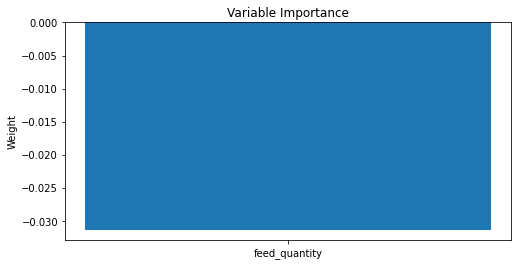

In [14]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(1), weights[:, 0])
ax.set_xticks(range(1))
ax.set_xticklabels(['feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [15]:
japonica_validation_features_X

,feed_quantity
mea_dt,
2021-07-21 03:00:00,0.0
2021-07-21 03:01:00,0.0
2021-07-21 03:02:00,0.0
2021-07-21 03:03:00,0.0
2021-07-21 03:04:00,0.0
...,...
2021-09-08 17:55:00,0.0
2021-09-08 17:56:00,0.0
2021-09-08 17:57:00,0.0


In [26]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 16202 nVar: 1


/tmp/ipykernel_3281954/1737833184.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']


In [27]:
y_date = japonica_validation_features_y.loc['2021-07-21 00:00':'2021-09-10 20:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 16202 nVar: 1
nCar: 16202 nVar: 1


/tmp/ipykernel_3281954/1228628032.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  y_date = japonica_validation_features_y.loc['2021-07-21 00:00':'2021-09-10 20:59']


16202


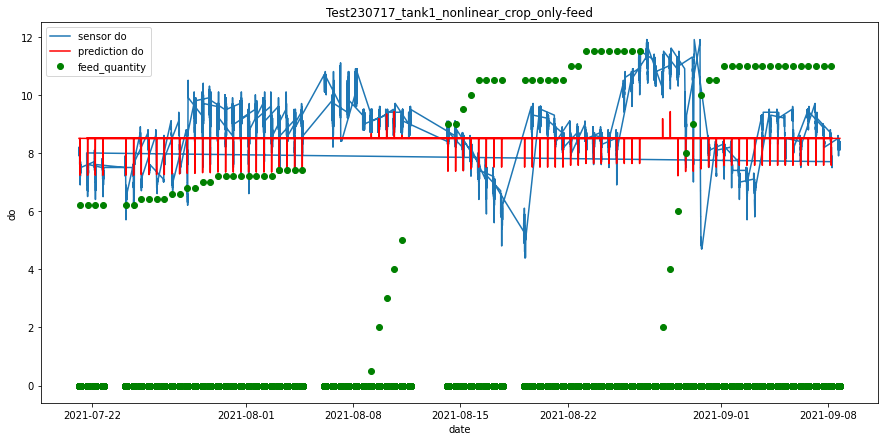

507/507 [==============================] - 2s 4ms/step - loss: 1.5055
MSE // MAE // R-squared  1.5055490732192993


In [28]:
grapeNEva(model,X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [29]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-09-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1


In [30]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 64800 nVar: 1


64800


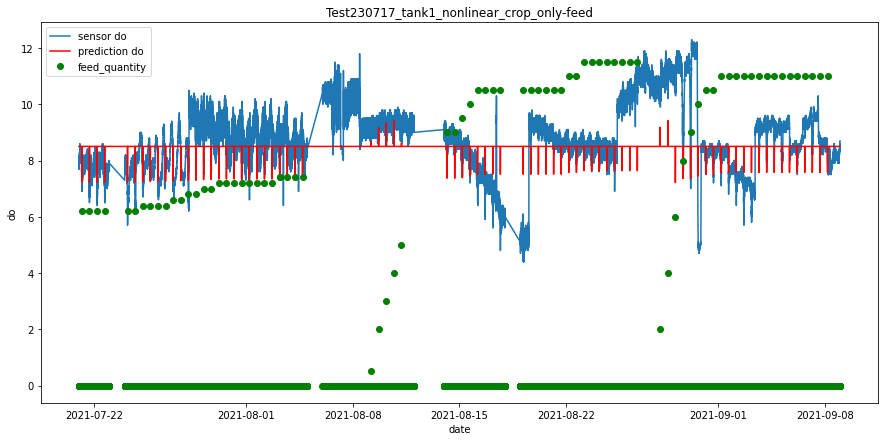

2025/2025 [==============================] - 5s 2ms/step - loss: 1.5411
MSE // MAE // R-squared  1.541116714477539


In [31]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [35]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-07-31 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14400 nVar: 1


In [36]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14400 nVar: 1
nCar: 14400 nVar: 1


14400


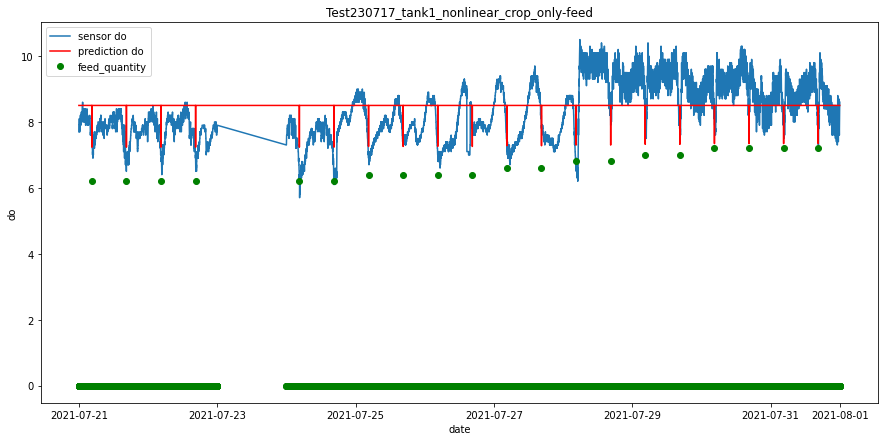

450/450 [==============================] - 1s 2ms/step - loss: 0.7513
MSE // MAE // R-squared  0.7513294219970703


In [37]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [38]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-07-21 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1
nCar: 1440 nVar: 1


In [39]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1
nCar: 1440 nVar: 1


1440


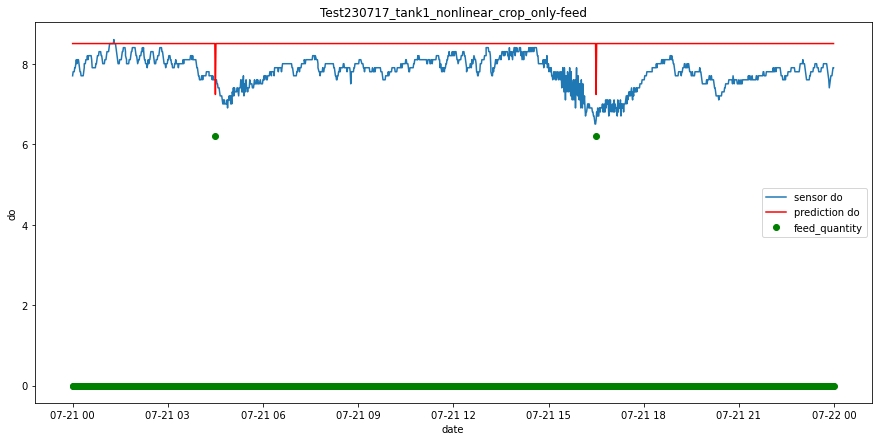

45/45 [==============================] - 0s 3ms/step - loss: 0.6070
MSE // MAE // R-squared  0.6069905757904053


In [40]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [42]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-07-21 11:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1


In [43]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 720 nVar: 1


720


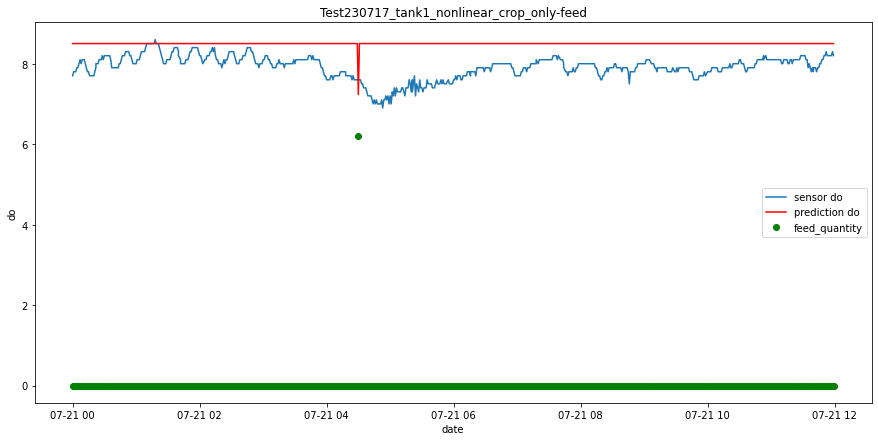

23/23 [==============================] - 0s 4ms/step - loss: 0.4298
MSE // MAE // R-squared  0.42981329560279846


In [44]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [45]:
japonica_validation_features.at['2021-07-21 08:00', 'feed_quantity'] = 6

X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-07-21 11:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1


In [46]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 720 nVar: 1


720


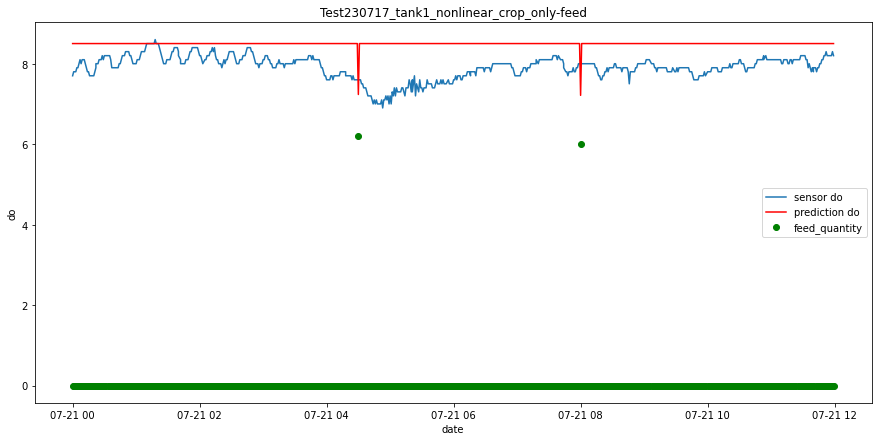

23/23 [==============================] - 0s 3ms/step - loss: 0.4303
MSE // MAE // R-squared  0.4303237199783325


In [47]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)